In [132]:
# External packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [133]:
import physo
import physo.learn.monitoring as monitoring

In [134]:
# Seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

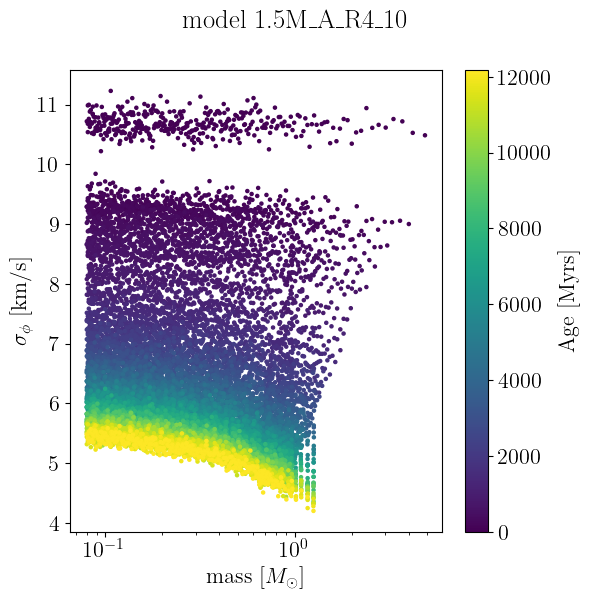

In [135]:
models=['1.5M_A_R4_10',
'500k_A_R2_10',
'500k_A_R4_10',
'500k_C_R4_10',
'250k_A_R2_25',
'250k_A_R2_25_vlk',
'250k_A_R2_10',
'250k_A_R2_5',
'250k_A_R4_25',
'250k_A_R4_25_imf50',
'250k_A_R4_25_lk',
'250k_A_R4_25_retr',
'250k_A_R4_25_vlk',
'250k_A_R4_10',
'250k_A_R4_10_retr',
'250k_B_R4_25',
'250k_B_R4_25_lk',
'250k_C_R2_10',
'250k_C_R4_25',
'250k_C_R4_25_lk',
'250k_C_R4_10',
'250k_W6_R4_25',
'250k_W6_R4_25_retr',
'500k_A_R4_LC_part1',
'500k_A_R4_LC_part2']

base_path = f"/pbs/throng/training/astroinfo2025/data/Nbody/"

def load_model_data_mass(model_name, base_path):
    # Read mass bin
    rad_m = pd.read_csv(base_path + model_name + "/mass/mass_0.0-0.5_mass_bin.dat", 
                        delimiter=" ", header=None)
    m = rad_m.to_numpy()

    # Read sigma_phi
    disp_phi_m = pd.read_csv(base_path + model_name + "/mass/mass_0.0-0.5_disp_phi.dat", 
                             delimiter=" ", header=None)
    s_phi_m = disp_phi_m.to_numpy()

    # Read v_phi
    vel_phi_m = pd.read_csv(base_path + model_name + "/mass/mass_0.0-0.5_vphi.dat", 
                            delimiter=" ", header=None)
    v_phi_m = vel_phi_m.to_numpy()

    # Read age
    age = pd.read_csv(base_path + model_name + "/age.dat",
                      sep=r"\s+", header=None).to_numpy().flatten()

    return {
        "age": age,
        "m": m,
        "disp_phi_m": s_phi_m,
        "v_phi_m": v_phi_m
    }

# --- Load model ---
i = 0
data_1 = load_model_data_mass(models[i], base_path)
m = data_1["m"]
s_phi_m = data_1["disp_phi_m"]
v_phi_m = data_1["v_phi_m"]
age = data_1["age"].flatten()

# --- Select snapshots ---
selected_indices = range(0, len(m), 100)
m_all = np.concatenate([m[idx] for idx in selected_indices])
s_phi_m_all = np.concatenate([s_phi_m[idx] for idx in selected_indices])
v_phi_m_all = np.concatenate([v_phi_m[idx] for idx in selected_indices])
age_all = np.concatenate([np.full_like(m[idx], age[idx]) for idx in selected_indices])

# --- Mass cut ---
mass_threshold = 5

mask_low = m_all < mass_threshold
mask_high = ~mask_low

# Lower-mass subset
m_low = m_all[mask_low]
s_phi_low = s_phi_m_all[mask_low]
v_phi_low = v_phi_m_all[mask_low]
age_low = age_all[mask_low]

# Higher-mass subset
m_high = m_all[mask_high]
s_phi_high = s_phi_m_all[mask_high]
v_phi_high = v_phi_m_all[mask_high]
age_high = age_all[mask_high]

#print(age_low.shape)
#print(age.shape)

# Plot1
fig, ax = plt.subplots(figsize=(6,6))
fig.suptitle("model " + models[i])
sc = ax.scatter(m_low, s_phi_low, c=age_low, cmap='viridis', s=5)
cbar = plt.colorbar(sc)
cbar.set_label("Age [Myrs]")
ax.set_xlabel(r"mass [$M_\odot$]")
ax.set_ylabel(r"$\sigma_\phi$ [km/s]")
ax.set_xscale('log')
plt.show()

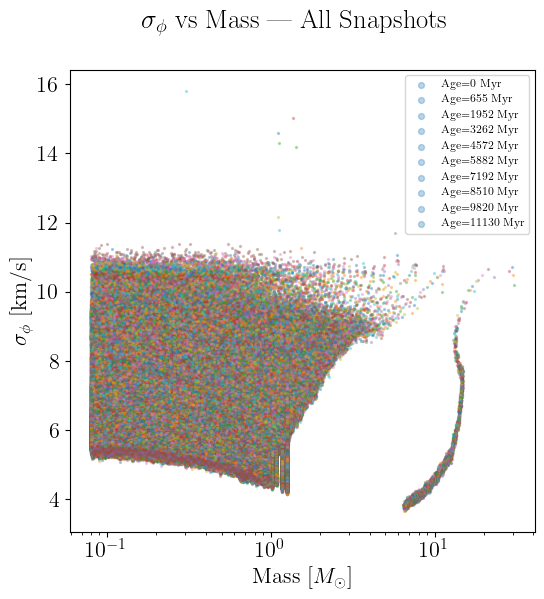

In [136]:
fig, ax = plt.subplots(figsize=(6,6))
fig.suptitle("$\sigma_\phi$ vs Mass — All Snapshots")

for i in range(len(age)):
    ax.scatter(m[i], s_phi_m[i], s=2, alpha=0.3,
               label=f"Age={age[i]:.0f} Myr" if i % 500 == 0 else None)

ax.set_xlabel(r"Mass [$M_\odot$]")
ax.set_ylabel(r"$\sigma_\phi$ [km/s]")
ax.set_xscale('log')
ax.legend(markerscale=3, fontsize=8)
plt.show()


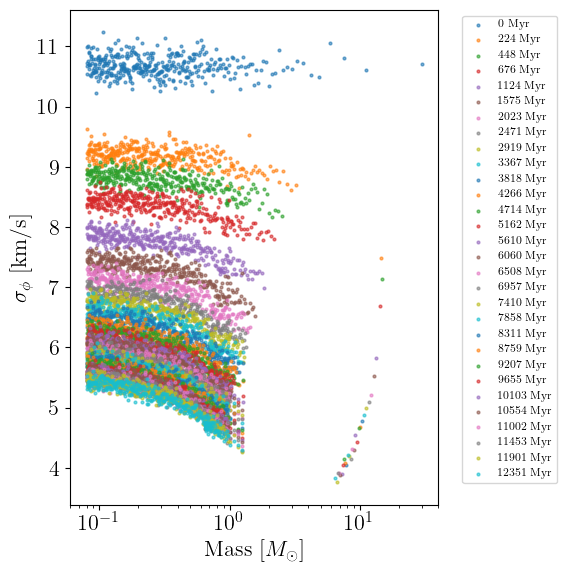

In [137]:
selected_indices = np.linspace(0, len(age)-1, 30, dtype=int)

fig, ax = plt.subplots(figsize=(6,6))
for i in selected_indices:
    ax.scatter(m[i], s_phi_m[i], s=4, alpha=0.6,
               label=f"{age[i]:.0f} Myr")

ax.set_xlabel(r"Mass [$M_\odot$]")
ax.set_ylabel(r"$\sigma_\phi$ [km/s]")
ax.set_xscale('log')
ax.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


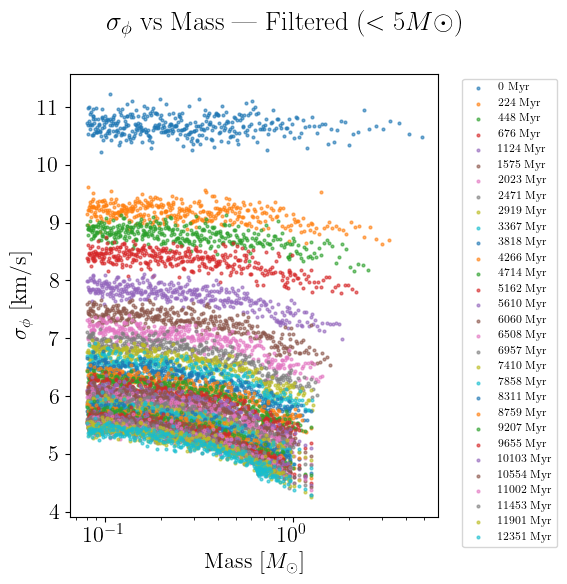

In [138]:
# Remove stars with mass > 5 for each snapshot
m_filtered = []
s_phi_filtered = []

for i in range(len(m)):
    mask = m[i] <= 5
    m_filtered.append(m[i][mask])
    s_phi_filtered.append(s_phi_m[i][mask])

# Plot and check
selected_indices = np.linspace(0, len(age)-1, 30, dtype=int)

fig, ax = plt.subplots(figsize=(6,6))
fig.suptitle("$\sigma_\phi$ vs Mass — Filtered ($<5 M\odot$)")

for i in selected_indices:
    ax.scatter(m_filtered[i], s_phi_filtered[i], s=4, alpha=0.6,
               label=f"{age[i]:.0f} Myr")

ax.set_xlabel(r"Mass [$M_\odot$]")
ax.set_ylabel(r"$\sigma_\phi$ [km/s]")
ax.set_xscale('log')
ax.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [139]:
# --- Parameters ---
mass_cut = 5.0               # filter: keep only M <= mass_cut
min_points_per_snapshot = 50 # skip snapshots with fewer points than this
normalize = True             # normalize data around ~1 (recommended for PhySO, see doc)
run_all_snapshots = False    # if False, will run only on selected_indices below
selected_indices = np.linspace(0, len(age)-1, 30, dtype=int)  # subset to run SR on if above is False

# Logging / visualization helpers for physo (optional)
save_path_training_curves = 'physo_training_curves.png'
save_path_log             = 'physo_demo.log'
run_logger     = lambda : monitoring.RunLogger(save_path = save_path_log, do_save = True)
run_visualiser = lambda : monitoring.RunVisualiser(epoch_refresh_rate = 1,
                                                   save_path = save_path_training_curves,
                                                   do_show   = False,
                                                   do_prints = True,
                                                   do_save   = True)

# utility: prepare X,y arrays for PhySO from one snapshot index i
def prepare_snapshot_for_physo(i, m_list, s_phi_list):
    """
    m_list: list/array where m_list[i] is 1D array of masses at snapshot i
    s_phi_list: same structure for sigma_phi
    returns: X (n_dim, N_points), y (N_points,)
    """
    # get per-star arrays
    m_i = np.asarray(m_list[i]).flatten()
    s_i = np.asarray(s_phi_list[i]).flatten()
    assert m_i.shape == s_i.shape, "mass and sigma arrays must have same length for snapshot"

    # apply mass filter
    mask = (m_i <= mass_cut)
    m_i = m_i[mask]
    s_i = s_i[mask]

    # remove NaNs and infs
    good = np.isfinite(m_i) & np.isfinite(s_i)
    m_i = m_i[good]
    s_i = s_i[good]

    # if too few points, return None to skip
    if len(m_i) < min_points_per_snapshot:
        return None, None

    # Build X as shape (n_dim, N). Here we use mass only as input variable.
    # If you have more per-star features (v_phi, metallicity...), include them as extra rows.
    X = np.vstack([m_i])   # shape (1, N)
    y = s_i                # shape (N,)

    # Optionally normalize so values are O(1) (helps physo free constants search)
    if normalize:
        # For each row of X, divide by median (avoid zero division)
        X_scale = np.median(np.abs(X), axis=1)
        X_scale[X_scale == 0] = 1.0  # safety
        X = X / X_scale[:, None]

        # scale y similarly
        y_scale = np.median(np.abs(y))
        if y_scale == 0:
            y_scale = 1.0
        y = y / y_scale

        # keep scaling factors to be able to rescale constants later if needed
        # return also scales maybe if you want to reconstruct physical expression
        return X, y, X_scale, y_scale

    return X, y, None, None

# wrapper to run physo.SR on one prepared X,y
def run_physo_on_snapshot(X, y, X_names=None, X_units=None, y_name='sigma_phi', y_units=None,
                          epochs=200, run_logger_fn=None, run_visualiser_fn=None, run_config=None):
    """
    X: (n_dim, N)
    y: (N,)
    Returns expression, logs
    """
    # names
    if X_names is None:
        X_names = [f"x{i}" for i in range(X.shape[0])]
    if X_units is None:
        X_units = [[0]*3 for _ in range(X.shape[0])]
    if y_units is None:
        y_units = [0]*3  # [L, T, M]

    # choose run_config
    if run_config is None:
        run_config = physo.config.config1.config1  # recommended for SR + DA (see docs), but adjust

    expression, logs = physo.SR(X, y,
                                X_names = X_names,
                                X_units = X_units,
                                y_name = y_name,
                                y_units = y_units,
                                fixed_consts = [1.0],
                                fixed_consts_units = [[0,0,0]],
                                # Free constants names (for display purposes)
                                free_consts_names = [ "rs"       , "vc"        ],
                                free_consts_units = [ [1, 0, 0] , [1, -1, 0] ],
                                op_names = ["mul", "add", "sub", "div", "inv", "n2", "sqrt", "neg", "exp", "log"],
                                get_run_logger     = run_logger_fn,
                                get_run_visualiser = run_visualiser_fn,
                                run_config = run_config,
                                parallel_mode = False,
                                epochs = epochs
                                )
    return expression, logs

# === Main loop: prepare and run SR per snapshot ===
results = []  # list of dicts {idx, age, expr, logs, scales}
indices = range(len(age)) if run_all_snapshots else selected_indices

for idx in indices:
    # prepare
    res = prepare_snapshot_for_physo(idx, m, s_phi_m)
    if res[0] is None:
        print(f"Skipping snapshot {idx} (age={age[idx]:.1f}) — not enough valid points")
        continue

    X, y, X_scale, y_scale = res

    # run physo
    print(f"Running PhySO on snapshot {idx} (age={age[idx]:.1f} Myr), N={X.shape[1]} points ...")
    expr, logs = run_physo_on_snapshot(X, y,
                                       X_names=["mass"],
                                       X_units=[[0,0,1]],  
                                       y_name="sigma_phi",
                                       y_units=[1,-1,0],    
                                       epochs=20,      # small number to quick test
                                       run_logger_fn=run_logger,
                                       run_visualiser_fn=run_visualiser,
                                       run_config=physo.config.config1.config1)

    # store results (keep expression object + scales to recover physical form)
    results.append({
        "idx": idx,
        "age": age[idx],
        "expr": expr,
        "logs": logs,
        "X_scale": X_scale,
        "y_scale": y_scale
    })

    # quick inspect top expression
    print("Best expr (pretty):")
    print(expr.get_infix_pretty())
    print("Sympy (evaluated consts):", expr.get_infix_sympy(evaluate_consts=True)[0])


Running PhySO on snapshot 0 (age=0.0 Myr), N=370 points ...
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
SR task started...


/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/batch_execute.py:80: UserWarning: Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
  warnings.warn(msg)
/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00000 ===========
-> Time 12.52 s
-> Memory Usage: 6982.50 MB

Overall best  at R=0.500943
-> Raw expression : 
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        

Best of epoch at R=0.500943
-> Raw expression : 
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        




/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00001 ===========
-> Time 55.84 s
-> Memory Usage: 7661.77 MB

Overall best  at R=0.500943
-> Raw expression : 
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        

Best of epoch at R=0.500338
-> Raw expression : 
        -rs          
─────────────────────
            ⎛   2⎞   
            ⎝1.0 ⎠   
     1.0 + ℯ       rs
mass⋅─────────────⋅──
         mass      vc




/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00002 ===========
-> Time 131.07 s
-> Memory Usage: 7757.18 MB

Overall best  at R=0.500943
-> Raw expression : 
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        

Best of epoch at R=0.500343
-> Raw expression : 
                               1                           
    ───────────────────────────────────────────────────────
                                                        0.5
    ⎛                                         0.5      ⎞   
    ⎜⎛                        0.5            ⎞         ⎟   
    ⎜⎜⎛             0.5      ⎞               ⎟         ⎟   
    ⎜⎜⎜      ⎛  1  ⎞         ⎟               ⎟         ⎟   
    ⎜⎜⎜mass⋅-⎜─────⎟    + 1.0⎟    - 1.0 + 1.0⎟    - 1.0⎟   
    ⎜⎜⎜      ⎜    2⎟         ⎟               ⎟         ⎟   
    ⎝⎝⎝      ⎝mass ⎠         ⎠               ⎠         ⎠   
vc

/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00003 ===========
-> Time 140.36 s
-> Memory Usage: 7912.82 MB

Overall best  at R=0.500943
-> Raw expression : 
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        

Best of epoch at R=0.500338
-> Raw expression : 
        ⎛      ⎛                        2    ⎞⎞
        ⎜      ⎜       ⎛     0.5      2⎞     ⎟⎟
mass⋅log⎝1.0 - ⎝-1.0 + ⎝- 1.0    + 1.0 ⎠ ⋅1.0⎠⎠
───────────────────────────────────────────────
                    ⎛mass⎞                     
                    ⎜────⎟                     
                    ⎝ vc ⎠                     




/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00004 ===========
-> Time 140.72 s
-> Memory Usage: 7912.81 MB

Overall best  at R=0.500943
-> Raw expression : 
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        

Best of epoch at R=0.500338
-> Raw expression : 
-  ⎛      ⎛                   2⎞                 ⎞    
  ⎜ 1    ⎝(1.0 - (1.0 - 1.0)) ⎠                 ⎟     
1⋅⎜────⋅ℯ                      ⋅1.0⋅mass⋅vc - vc⎟⋅1.0 
  ⎝mass                                         ⎠     




/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00005 ===========
-> Time 120.18 s
-> Memory Usage: 7912.93 MB

Overall best  at R=0.500943
-> Raw expression : 
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        

Best of epoch at R=0.500338
-> Raw expression : 
       ⎛         0.5⎞
       ⎜⎛      2⎞   ⎟
       ⎜⎜⎛   2⎞ ⎟   ⎟
       ⎜⎜⎝1.0 ⎠ ⎟   ⎟
       ⎜⎜───────⎟   ⎟
       ⎝⎝  1.0  ⎠   ⎠
      ℯ              
-vc + ───────────────
         ⎛ mass ⎞    
         ⎜──────⎟    
         ⎜⎛mass⎞⎟    
         ⎜⎜────⎟⎟    
         ⎜⎜⎛1 ⎞⎟⎟    
         ⎜⎜⎜──⎟⎟⎟    
         ⎝⎝⎝vc⎠⎠⎠    




/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00006 ===========
-> Time 140.26 s
-> Memory Usage: 7853.55 MB

Overall best  at R=0.500943
-> Raw expression : 
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        

Best of epoch at R=0.500338
-> Raw expression : 
             vc              
─────────────────────────────
                            2
⎛         1                ⎞ 
⎜──────────────────── - 1.0⎟ 
⎜⎛       -1         ⎞      ⎟ 
⎜⎜──────────────────⎟      ⎟ 
⎜⎜   ⎛      1      ⎞⎟      ⎟ 
⎜⎜log⎜─────────────⎟⎟      ⎟ 
⎜⎜   ⎜            2⎟⎟      ⎟ 
⎜⎜   ⎜       ⎛ 1 ⎞ ⎟⎟      ⎟ 
⎜⎜   ⎜-1.0 + ⎜───⎟ ⎟⎟      ⎟ 
⎝⎝   ⎝       ⎝1.0⎠ ⎠⎠      ⎠ 




/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00007 ===========
-> Time 140.80 s
-> Memory Usage: 7975.00 MB

Overall best  at R=0.500943
-> Raw expression : 
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        

Best of epoch at R=0.500338
-> Raw expression : 
            -vc             
────────────────────────────
                1.0         
mass⋅vc⋅────────────────────
                      2     
         ⎛        0.5⎞  1.0 
        -⎝mass⋅-vc   ⎠ ⋅────
                        mass




/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00008 ===========
-> Time 141.66 s
-> Memory Usage: 8068.53 MB

Overall best  at R=0.500943
-> Raw expression : 
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        

Best of epoch at R=0.500338
-> Raw expression : 
        ⎛                                 2⎞
        ⎜⎛                              2⎞ ⎟
        ⎜⎜       ⎛         -1          ⎞ ⎟ ⎟
    -log⎜⎜-1.0 + ⎜─────────────────────⎟ ⎟ ⎟
        ⎜⎜       ⎜                  0.5⎟ ⎟ ⎟
        ⎜⎜       ⎜⎛             0.5⎞   ⎟ ⎟ ⎟
        ⎜⎜       ⎜⎜⎛          2⎞   ⎟   ⎟ ⎟ ⎟
        ⎝⎝       ⎝⎝⎝-1.0 + 1.0 ⎠   ⎠   ⎠ ⎠ ⎠
vc⋅ℯ                                        




/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00009 ===========
-> Time 141.23 s
-> Memory Usage: 7915.72 MB

Overall best  at R=0.500943
-> Raw expression : 
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        

Best of epoch at R=0.500338
-> Raw expression : 
                 ⎛                         0.5      ⎞
                 ⎜⎛mass⋅(1.0 - 1.0) + mass⎞         ⎟
     mass⋅vc⋅-log⎜⎜───────────────────────⎟    + 1.0⎟
                 ⎝⎝         mass          ⎠         ⎠
vc + ────────────────────────────────────────────────
                           mass                      




/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00010 ===========
-> Time 140.19 s
-> Memory Usage: 8009.18 MB

Overall best  at R=0.500943
-> Raw expression : 
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        

Best of epoch at R=0.500338
-> Raw expression : 
                2         
      ⎛     0.5⎞          
      ⎝-mass   ⎠       0.5
      ─────────── + 1.0   
         mass             
     ℯ                    
vc - ─────────────────────
             ⎛1 ⎞         
             ⎜──⎟         
             ⎝vc⎠         




/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00011 ===========
-> Time 137.88 s
-> Memory Usage: 7965.30 MB

Overall best  at R=0.500943
-> Raw expression : 
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        

Best of epoch at R=0.500338
-> Raw expression : 
   ⎛ ⎛                    2⎞      ⎞
   ⎜ ⎜⎛       1.0        ⎞ ⎟      ⎟
   ⎜ ⎜⎜──────────────────⎟ ⎟      ⎟
   ⎜ ⎜⎜                 2⎟ ⎟      ⎟
   ⎜ ⎜⎜     ⎛    vc    ⎞ ⎟ ⎟      ⎟
   ⎜ ⎜⎜mass⋅⎜──────────⎟ ⎟ ⎟      ⎟
   ⎜ ⎜⎜     ⎜       0.5⎟ ⎟ ⎟      ⎟
   ⎜ ⎝⎝     ⎝vc⋅mass   ⎠ ⎠ ⎠      ⎟
vc⋅⎝ℯ                        - 1.0⎠




/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00012 ===========
-> Time 139.54 s
-> Memory Usage: 8078.23 MB

Overall best  at R=0.500943
-> Raw expression : 
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        

Best of epoch at R=0.500338
-> Raw expression : 
                        0.5
⎛           2          ⎞   
⎜         vc           ⎟   
⎜──────────────────────⎟   
⎜   mass               ⎟   
⎜ ───────── - 1.0 + 1.0⎟   
⎜ ⎛  -1   ⎞            ⎟   
⎜ ⎜───────⎟            ⎟   
⎜ ⎜⎛mass ⎞⎟            ⎟   
⎜ ⎜⎜─────⎟⎟            ⎟   
⎜ ⎜⎜    2⎟⎟            ⎟   
⎜ ⎝⎝mass ⎠⎠            ⎟   
⎝ℯ                     ⎠   




/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00013 ===========
-> Time 123.35 s
-> Memory Usage: 7984.83 MB

Overall best  at R=0.500943
-> Raw expression : 
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        

Best of epoch at R=0.500338
-> Raw expression : 
   ⎛   -(mass + mass + mass)           1.0⎞     
vc⋅⎜rs⋅────────────────────── - 1.0 + ℯ   ⎟ + vc
   ⎝          mass⋅rs                     ⎠     




/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00014 ===========
-> Time 156.02 s
-> Memory Usage: 8011.18 MB

Overall best  at R=0.500943
-> Raw expression : 
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        

Best of epoch at R=0.500338
-> Raw expression : 
                   1                   
───────────────────────────────────────
⎛                mass                 ⎞
⎜─────────────────────────────────────⎟
⎜⎛                 1                 ⎞⎟
⎜⎜───────────────────────────────────⎟⎟
⎜⎜⎛  ⎛                           2⎞ ⎞⎟⎟
⎜⎜⎜  ⎜⎛           ⎛   0.5      ⎞⎞ ⎟ ⎟⎟⎟
⎜⎜⎜  ⎝⎝-1.0 + 1.0⋅⎝1.0    + 1.0⎠⎠ ⎠ ⎟⎟⎟
⎜⎜⎜-ℯ                               ⎟⎟⎟
⎜⎜⎜─────────────────────────────────⎟⎟⎟
⎜⎜⎜             ⎛mass⎞              ⎟⎟⎟
⎜⎜⎜             ⎜────⎟              ⎟⎟⎟
⎜⎜⎜             ⎜⎛1 ⎞⎟              ⎟⎟⎟
⎜⎜⎜             ⎜⎜──⎟⎟              ⎟⎟⎟
⎝⎝

/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00015 ===========
-> Time 159.48 s
-> Memory Usage: 8166.36 MB

Overall best  at R=0.500943
-> Raw expression : 
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        

Best of epoch at R=0.500338
-> Raw expression : 
     ⎛                           2⎞         
     ⎜              ⎛      0.5  ⎞ ⎟         
     ⎜              ⎜  mass     ⎟ ⎟      1  
vc + ⎜-mass⋅vc + vc⋅⎜───────────⎟ ⎟⋅1.0⋅────
     ⎜              ⎜        1.0⎟ ⎟     mass
     ⎝              ⎝-1.0 + ℯ   ⎠ ⎠         




/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00016 ===========
-> Time 159.46 s
-> Memory Usage: 8259.84 MB

Overall best  at R=0.500943
-> Raw expression : 
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        

Best of epoch at R=0.500338
-> Raw expression : 
                         vc                   
-vc + ────────────────────────────────────────
      ⎛                  1                   ⎞
      ⎜──────────────────────────────────────⎟
      ⎜            ⎛rs⎞                      ⎟
      ⎜         log⎜──⎟⋅1.0 - 1.0 + 1.0 + 1.0⎟
      ⎜            ⎝rs⎠                      ⎟
      ⎜   mass⋅ℯ                             ⎟
      ⎜vc⋅───────────────────────────────────⎟
      ⎝                 mass⋅vc              ⎠




/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00017 ===========
-> Time 148.70 s
-> Memory Usage: 8166.38 MB

Overall best  at R=0.500943
-> Raw expression : 
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        

Best of epoch at R=0.500338
-> Raw expression : 
                                                2            
    ⎛                    1                     ⎞             
    ⎜──────────────────────────────────────────⎟  - 1.0 + 1.0
    ⎜⎛                  mass                  ⎞⎟             
    ⎜⎜────────────────────────────────────────⎟⎟             
    ⎝⎝1.0⋅(mass - (mass + mass + mass + mass))⎠⎠             
vc⋅ℯ                                                         




/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00018 ===========
-> Time 147.33 s
-> Memory Usage: 8204.45 MB

Overall best  at R=0.500943
-> Raw expression : 
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        

Best of epoch at R=0.500338
-> Raw expression : 
                 1             
    ───────────────────────────
          ⎛         1   ⎞      
          ⎜mass - ──────⎟      
          ⎜       ⎛-1  ⎞⎟      
          ⎜       ⎜────⎟⎟      
       0.5⎜       ⎝mass⎠⎟      
    log   ⎜─────────────⎟ - 1.0
          ⎝    mass     ⎠      
vc⋅ℯ                           




/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00019 ===========
-> Time 141.13 s
-> Memory Usage: 8322.79 MB

Overall best  at R=0.500943
-> Raw expression : 
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        

Best of epoch at R=0.500338
-> Raw expression : 
               2
⎛   mass⋅vc   ⎞ 
⎜─────────────⎟ 
⎜  vc      0.5⎟ 
⎜───────⋅vc   ⎟ 
⎜    1        ⎟ 
⎜vc⋅────      ⎟ 
⎝   mass      ⎠ 


Best expr (pretty):
      rs                      
─────────────── - vc + vc + vc
        mass⋅vc               
        ───────               
    rs  mass⋅vc               
1.0⋅──⋅ℯ                      
    vc                        
Sympy (evaluated consts): -0.00099994282955848 - 0.00099994282955848*exp(-1)
Running PhySO on snapshot 171 (age=224.0 Myr), N=363 points ...
Parallel mode is not available because physo is being ran from a notebook using 'spawn

/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/batch_execute.py:80: UserWarning: Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
  warnings.warn(msg)
/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00000 ===========
-> Time 8.50 s
-> Memory Usage: 7854.54 MB

Overall best  at R=0.500345
-> Raw expression : 
                                                 0.5
   ⎛   ⎛       ⎛               1        ⎞⎞      ⎞   
   ⎜   ⎜mass - ⎜-mass - ────────────────⎟⎟      ⎟   
   ⎜   ⎜       ⎜                       2⎟⎟      ⎟   
   ⎜   ⎜       ⎜        ⎛          0.5⎞ ⎟⎟      ⎟   
   ⎜   ⎜       ⎜        ⎜ ⎛  rs   ⎞   ⎟ ⎟⎟      ⎟   
   ⎜   ⎜       ⎜        ⎜-⎜───────⎟   ⎟ ⎟⎟      ⎟   
   ⎜   ⎜       ⎝        ⎝ ⎝mass⋅rs⎠   ⎠ ⎠⎟      ⎟   
vc⋅⎜log⎜─────────────────────────────────⎟ - 1.0⎟   
   ⎝   ⎝              mass               ⎠      ⎠   

Best of epoch at R=0.500345
-> Raw expression : 
                                                 0.5
   ⎛   ⎛       ⎛               1        ⎞⎞      ⎞   
   ⎜   ⎜mass - ⎜-mass - ────────────────⎟⎟      ⎟   
   ⎜   ⎜       ⎜                       2⎟⎟      ⎟   
   ⎜   ⎜       ⎜        ⎛          0.5⎞ ⎟⎟      ⎟   
   ⎜   ⎜       ⎜        ⎜ 

/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


=========== Epoch 00001 ===========
-> Time 144.28 s
-> Memory Usage: 7983.27 MB

Overall best  at R=0.500345
-> Raw expression : 
   ⎛    ⎛            -1      ⎞            ⎞
   ⎜    ⎜mass⋅vc⋅────────────⎟            ⎟
   ⎜    ⎜        vc + vc + vc⎟            ⎟
   ⎜ log⎜────────────────────⎟            ⎟
   ⎜    ⎝        mass        ⎠            ⎟
   ⎜ ───────────────────────── + 1.0      ⎟
   ⎜            1.0                       ⎟
vc⋅⎝ℯ                                - 1.0⎠

Best of epoch at R=0.500345
-> Raw expression : 
   ⎛    ⎛            -1      ⎞            ⎞
   ⎜    ⎜mass⋅vc⋅────────────⎟            ⎟
   ⎜    ⎜        vc + vc + vc⎟            ⎟
   ⎜ log⎜────────────────────⎟            ⎟
   ⎜    ⎝        mass        ⎠            ⎟
   ⎜ ───────────────────────── + 1.0      ⎟
   ⎜            1.0                       ⎟
vc⋅⎝ℯ                                - 1.0⎠




/pbs/home/g/gadrat/.local/lib/python3.11/site-packages/physo/physym/prior.py:557: UserWarning: No trigonometric functions detected, (NestedTrigonometryPrior (tokens = [], nesting forbidden)), this prior will be ignored.
  warnings.warn("No trigonometric functions detected, (%s), this prior will be ignored." % (self))


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fb5b39cdee0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 